# Control the corrected skin temperature for ERA5

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
from fsspec.implementations.local import LocalFileSystem
fs = LocalFileSystem()

%matplotlib inline

In [2]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import fsspec
import json
import intake

import dask
import dask_hpcconfig
from distributed import Client
from dask.distributed import Client, LocalCluster


In [3]:
cluster = dask_hpcconfig.cluster("datarmor", **{})
client = Client(cluster)
cluster.scale(jobs=1)

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


>> Function definition START

In [3]:
def Arc_Bat(ztype='isol1000') :

        locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
        locfile='bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['Bathymetry'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [4]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=1
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return

In [5]:
def time_axis(in_array,lyear):    # Rebuild the time axis 
    new_time=pd.date_range(start=str(lyear)+'-01-01',periods=in_array.dims['time_counter'],freq='H',inclusive='left')
    #print('        Year treated '+str(year)+' has '+str(ds_skt.dims['time_counter'])+' hours')
    return new_time

>> Function definition END

# CREG025.L75  Grid

In [6]:
GRIDPATH='/home1/scratch/ctalandi/CREG025.L75/CREG025.L75-I/'
ds_grd=xr.open_dataset(GRIDPATH+'CREG025.L75_byte_mask.nc')
ds_grd
tmask2D=ds_grd['tmask'].isel(z=0,t=0)

# CREG025.L75  Bathymetry

In [7]:
locpath='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
locfile='CREG025.L75_domain_cfg.nc'
fieldbat=xr.open_dataset(locpath+locfile)

# Read the corrected ERA skin temperature

In [8]:
lyear=2000

In [12]:
PATHIN='/home1/scratch/ctalandi/PREPOST/ERA5-CREG025.L75/skt_diff/'
ds_skt=xr.open_dataset(PATHIN+'CREG025.L75_drowned_skt_diff_ERA5_y'+str(lyear)+'.nc')
ds_skt=ds_skt.chunk({'time_counter':512})
ds_skt

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) timedelta64[ns] 36524 days 00:00:00 ... 3688...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    skt           (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [13]:
# Rebuild the time axis 
new_time=pd.date_range(start=str(lyear)+'-01-01',end=str(lyear+1)+'-01-01',freq='H',inclusive='left')
new_time
ds_skt=ds_skt.assign_coords({'time_counter':new_time})
ds_skt

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2000-01-01 ... 2000-12-31T23:...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    skt           (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [14]:
ds_skt['skt_diff']=xr.where(tmask2D == 0.,np.nan, ds_skt['skt_diff'])

In [15]:
if False:
    plt.figure(figsize=(20,15)) 
    ds_skt['skt_diff'].isel(time_counter=20).plot(vmin=-50.,vmax=50.,cmap='Spectral_r')

# Read the original ERA t2m air temperature

In [16]:
PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/'
ds_t2m=xr.open_dataset(PATHIN+'t2/CREG025.L75_drowned_t2_ERA5_y'+str(lyear)+'.nc')#,chunks='auto')
ds_t2m=ds_t2m.chunk({'time_counter':512})
ds_t2m

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) timedelta64[ns] 36524 days 00:00:00 ... 3688...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    t2            (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [17]:
# Rebuild the time axis 
new_time=pd.date_range(start=str(lyear)+'-01-01',periods=8784,freq='H',inclusive='left')
new_time
ds_t2m=ds_t2m.assign_coords({'time_counter':new_time})
ds_t2m

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, time_counter: 8784)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2000-01-01 ... 2000-12-31T23:...
Dimensions without coordinates: y, x
Data variables:
    longitude     (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    latitude      (y, x) float32 dask.array<chunksize=(603, 528), meta=np.ndarray>
    t2            (time_counter, y, x) float32 dask.array<chunksize=(512, 603, 528), meta=np.ndarray>
Attributes:
    title:    data to nemo bilin Mapping

In [18]:
# Convert into DegC
ds_t2m['t2']=xr.where(tmask2D == 0.,np.nan, ds_t2m['t2']-273.)

In [19]:
# Add the full correction
ds_t2m['t2cor']=(ds_t2m['t2']-ds_skt['skt_diff']).compute()

# Identify grid points where the time-series will be plot 

In [10]:
bx_SVAL={'name':'SVA','lon_min':320,'lon_max':320,'lat_min':350,'lat_max':350}
bx_LAPT={'name':'LAP','lon_min':355,'lon_max':355,'lat_min':500,'lat_max':500}
bx_BGYR={'name':'BGY','lon_min':180,'lon_max':180,'lat_min':500,'lat_max':500}
bx_BARE={'name':'BAR','lon_min':400,'lon_max':400,'lat_min':350,'lat_max':350}
bx_EURA={'name':'EUR','lon_min':320,'lon_max':320,'lat_min':420,'lat_max':420}

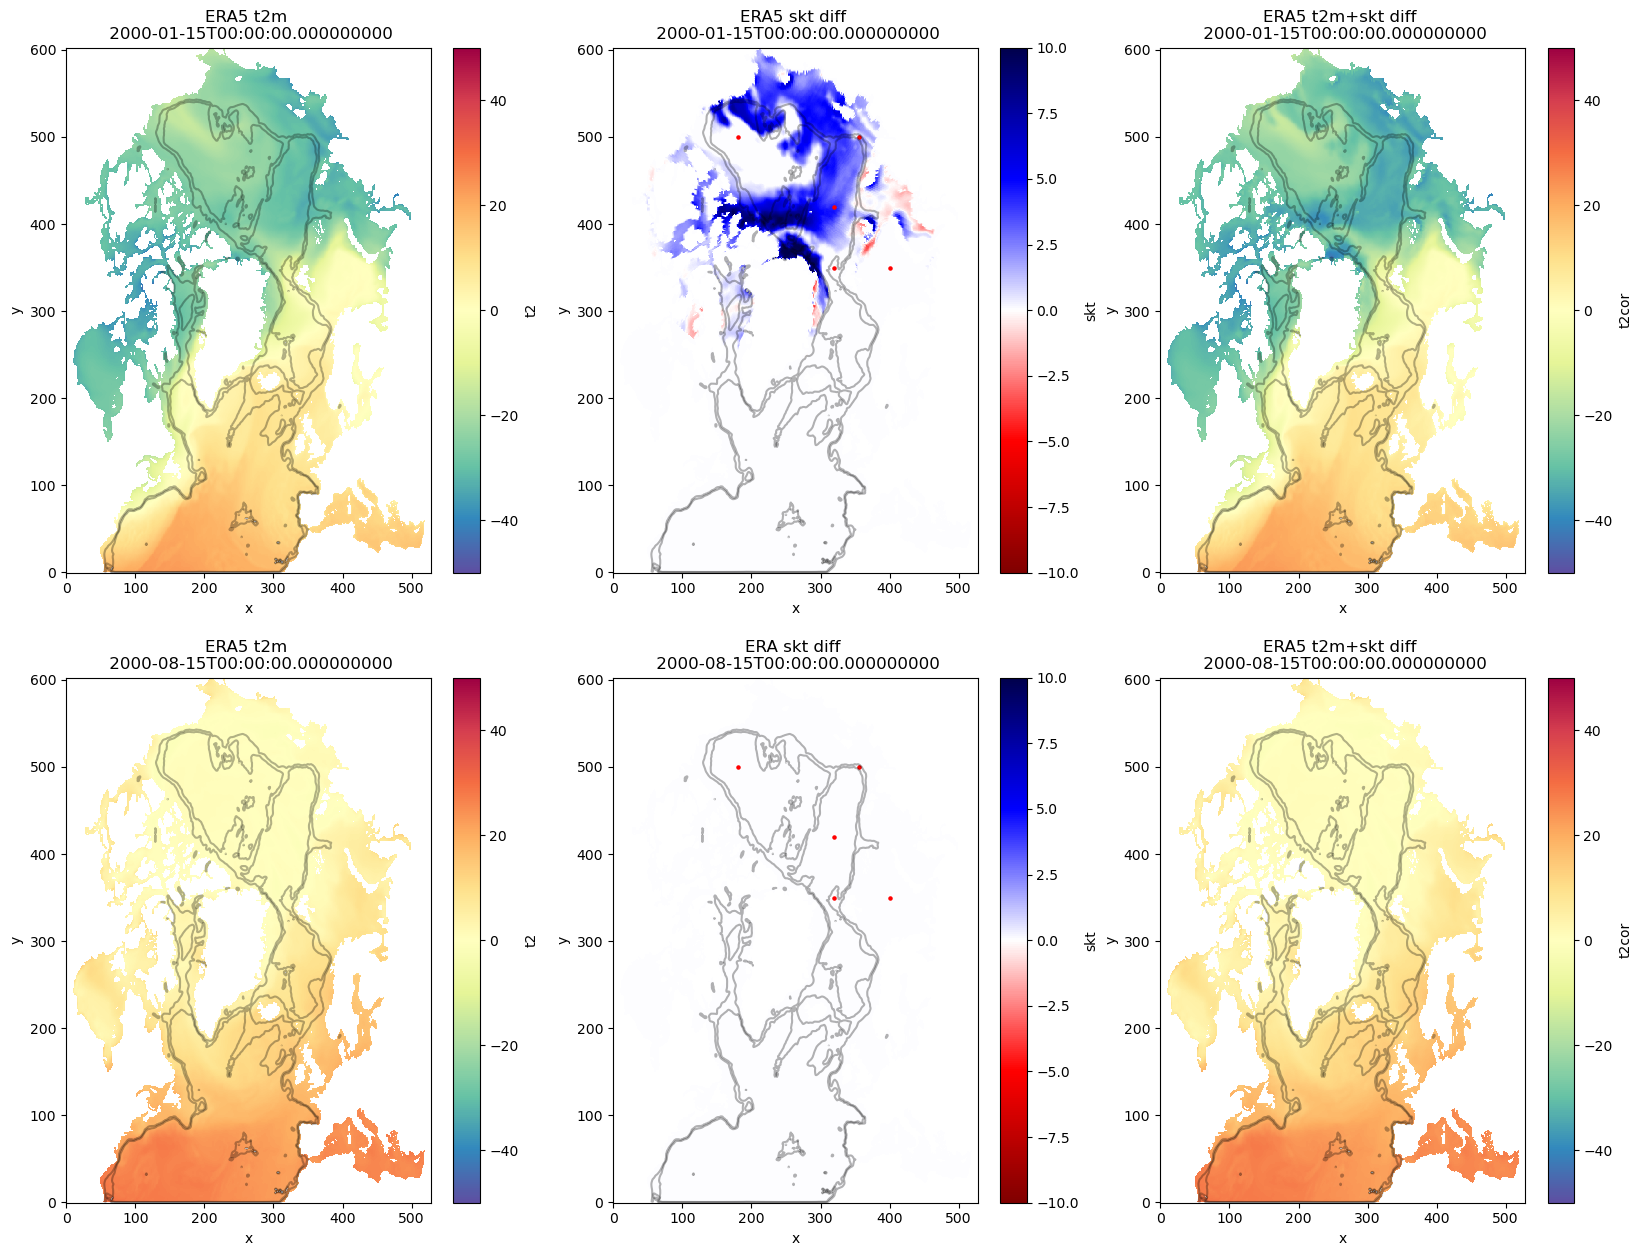

In [25]:
plt.figure(figsize=(20,15))

iter='2000-01-15 00:00:00' # For winter 
plt.subplot(231)
ds_t2m['t2'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.title('ERA5 t2m \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(232)
ds_skt['skt'].sel(time_counter=iter).plot(cmap='seismic_r',vmin=-10.,vmax=10.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
plt.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
plt.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')
plt.title('ERA5 skt diff \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(233)
ds_t2m['t2cor'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)

plt.title('ERA5 t2m+skt diff \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

iter='2000-08-15 00:00:00' # For Summer 
plt.subplot(234)
ds_t2m['t2'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.title('ERA5 t2m \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(235)
ds_skt['skt'].sel(time_counter=iter).plot(cmap='seismic_r',vmin=-10.,vmax=10.)
plt.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
plt.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
plt.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
plt.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.title('ERA skt diff \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))

plt.subplot(236)
ds_t2m['t2cor'].sel(time_counter=iter).plot(cmap='Spectral_r',vmin=-50.,vmax=50.)
fieldbat['bathy_meter'].isel(t=0).plot.contour(levels=[500.,2000.],colors='k',alpha=0.3)
plt.title('ERA5 t2m+skt diff \n '+str(ds_t2m['time_counter'].sel(time_counter=iter).values))


if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_t2m_sktdiff_y'+str(lyear)+'.png',dpi=300)


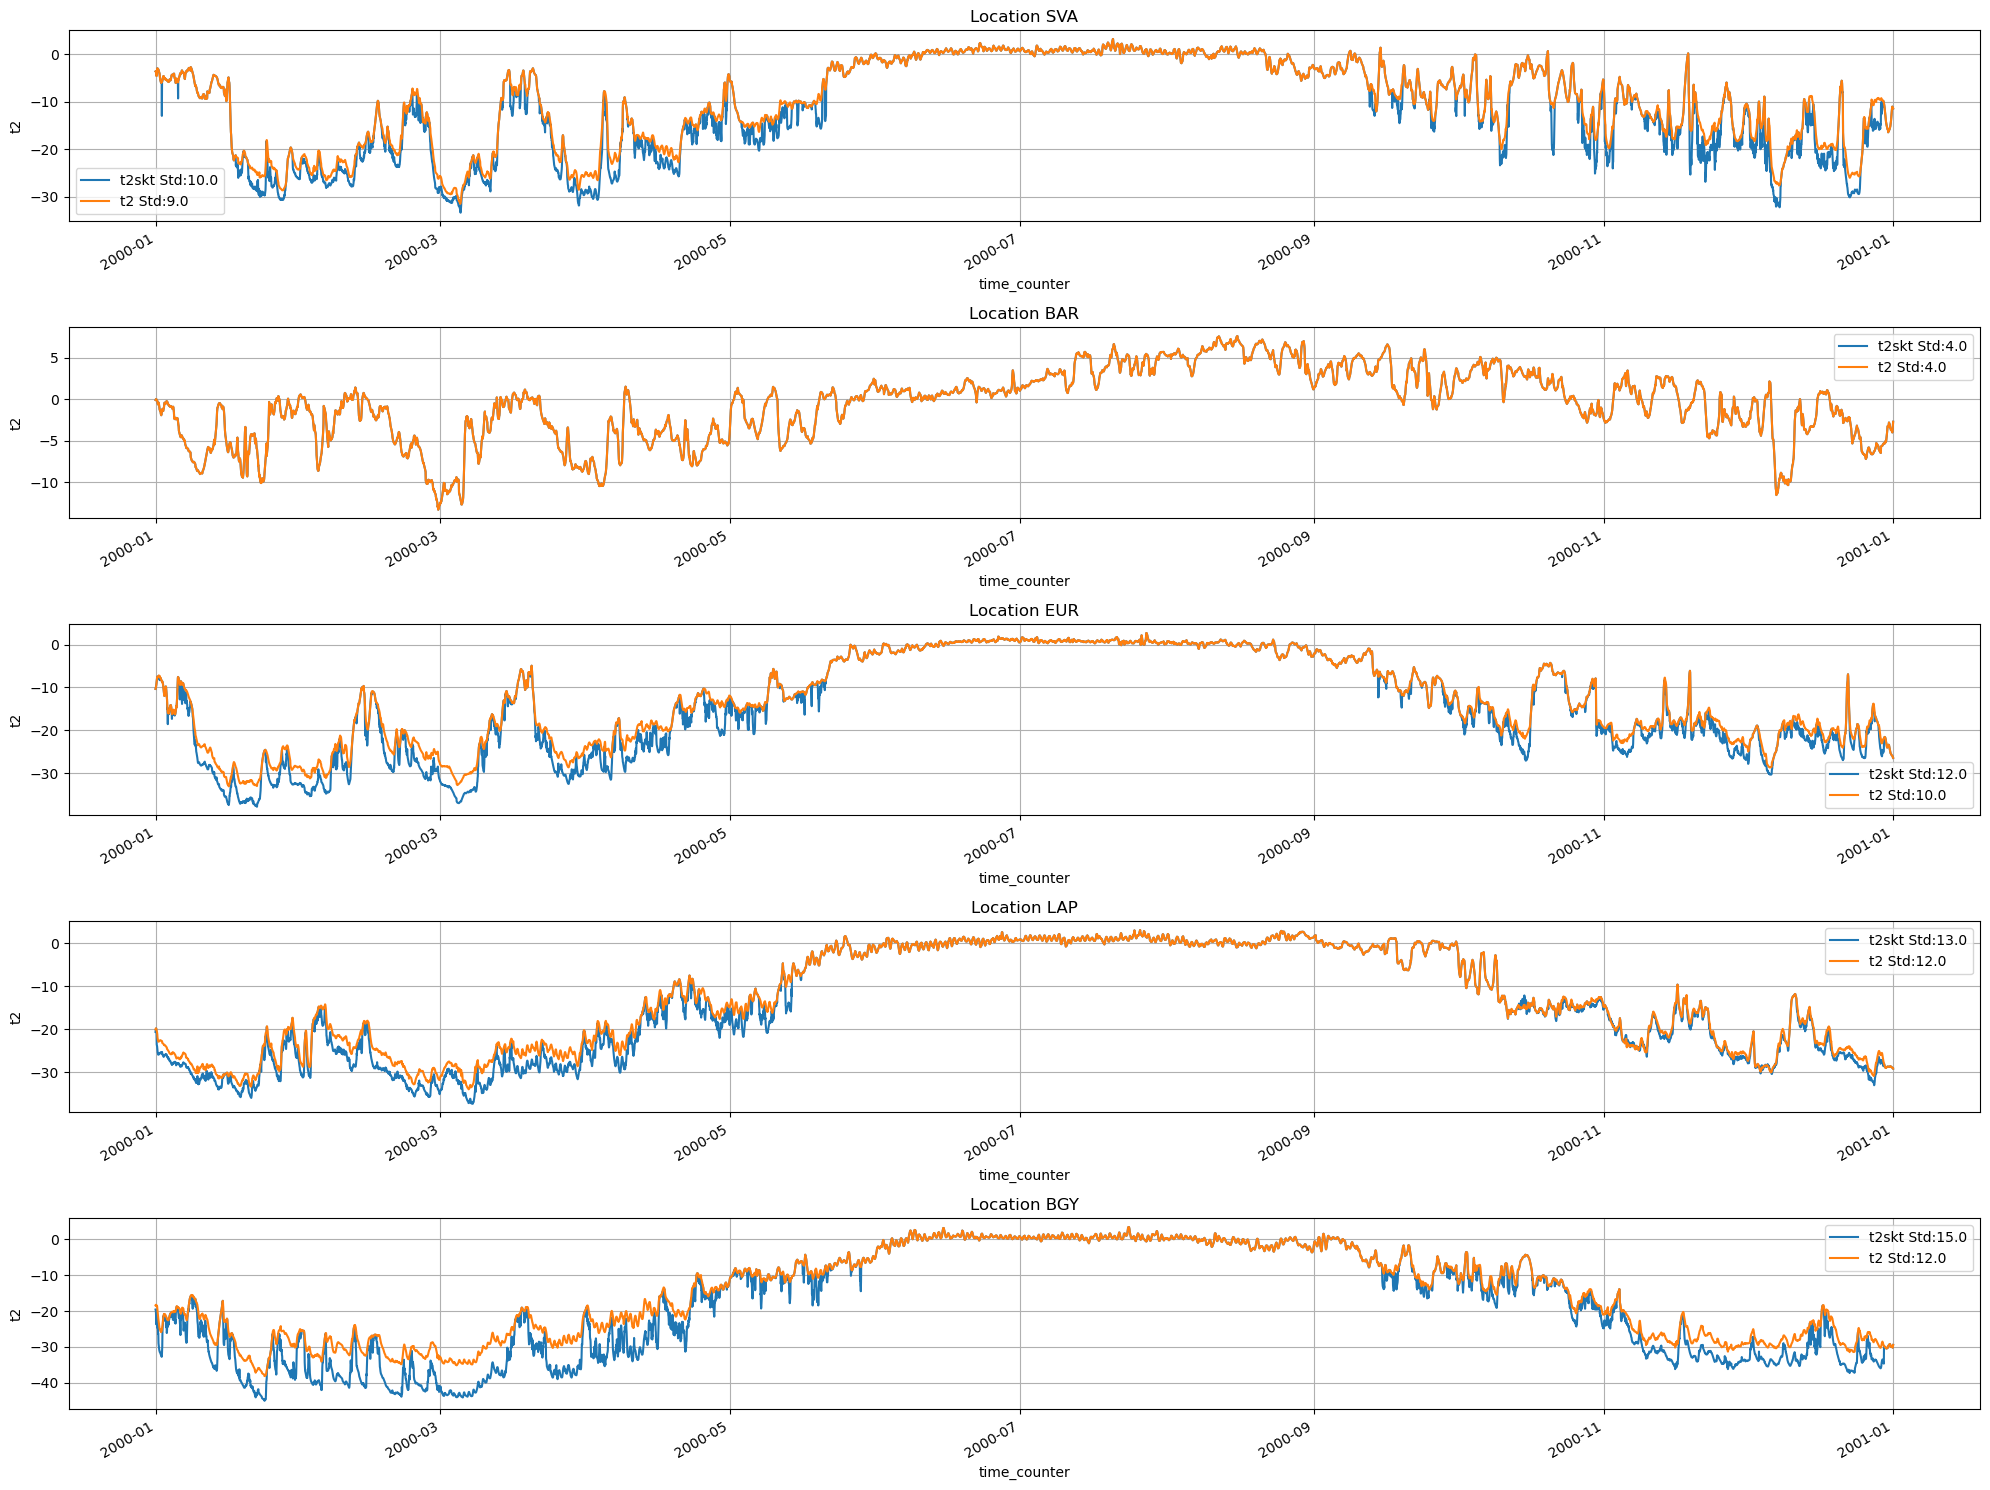

In [23]:
plt.figure(figsize=(20,15))

plt.subplot(511)
std_t2m=ds_t2m['t2'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_SVAL['lon_min'],y=bx_SVAL['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))

plt.title('Location '+bx_SVAL['name'])
plt.legend()
plt.grid(True)

plt.subplot(512)
std_t2m=ds_t2m['t2'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_BARE['lon_min'],y=bx_BARE['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_BARE['name'])
plt.legend()
plt.grid(True)

plt.subplot(513)
std_t2m=ds_t2m['t2'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_EURA['lon_min'],y=bx_EURA['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_EURA['name'])
plt.legend()
plt.grid(True)

plt.subplot(514)
std_t2m=ds_t2m['t2'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_LAPT['lon_min'],y=bx_LAPT['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_LAPT['name'])
plt.legend()
plt.grid(True)

plt.subplot(515)
std_t2m=ds_t2m['t2'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).std(dim='time_counter').values
std_cor=ds_t2m['t2cor'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).std(dim='time_counter').values
ds_t2m['t2cor'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).plot(label='t2skt Std:'+str(np.round(std_cor)))
ds_t2m['t2'].isel(x=bx_BGYR['lon_min'],y=bx_BGYR['lat_min']).plot(label='t2 Std:'+str(np.round(std_t2m)))
plt.title('Location '+bx_BGYR['name'])
plt.legend()
plt.grid(True)

plt.tight_layout()

if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_t2m_sktdiff_TiSe_y'+str(lyear)+'.png',dpi=300)


# Define a function that will apply the correction and save into zarr 

In [12]:
def corr_t2skt(tmask2D,zyear):
    print('Current year : '+str(zyear))
    PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/'
    
    # Read fields 
    ds_in=xr.open_dataset(PATHIN+'t2/CREG025.L75_drowned_t2_ERA5_y'+str(zyear)+'.nc')
    timeax=time_axis(ds_in,zyear)
    ds_in=ds_in.assign_coords({'time_counter':timeax})
    ds_t2m=ds_in.chunk({'time_counter':1024})
    
    ds_in=xr.open_dataset(PATHIN+'skt_diff/CREG025.L75_drowned_skt_diff_ERA5_y'+str(zyear)+'.nc')
    ds_in=ds_in.assign_coords({'time_counter':timeax})
    ds_skt=ds_in.chunk({'time_counter':1024})
    print('        Input t2 & skt read')
    
    # Apply a mask on the skt field
    ds_skt['skt_diff']=xr.where(tmask2D == 0.,np.nan, ds_skt['skt_diff'])    
    #print('    ds_skt',ds_skt.dims)

    # Convert t2m into DegC and apply also a mask
    ds_t2m['t2']=xr.where(tmask2D == 0.,np.nan, ds_t2m['t2']-273.)
    #print('    ds_t2m',ds_t2m.dims)
    
    # Apply the correction
    t2skt=ds_t2m['t2']-ds_skt['skt_diff']
    t2skt.name='t2skt'
    #print(t2skt.dims)
    print('        Correction applied')
    
    # Rebuild the time axis 
    new_time=pd.date_range(start=str(lyear)+'-01-01',periods=t2skt.shape[2],freq='H',inclusive='left')
    print('        Year treated '+str(year)+' has '+str(t2skt.shape[2])+' hours')
    
    # Build a datasset before saving
    if True:
       
        if False: # This does not ork properly or is too long 
            print('        Build a new dataset') 
            ds_outO=xr.Dataset()
            ds_outO['t2skt']=(('y','x','time_counter'),ds_t2m['t2skt'].values)
            ds_outO.coords['time_counter']=(('time_counter'),new_time)

            ds_out=ds_outO.chunk({'time_counter':512})
            ds_out['longitude']=(('y','x'),ds_t2m['longitude'].values)
            ds_out['latitude']=(('y','x'),ds_t2m['latitude'].values)
            ds_out=ds_out.set_coords(['time_counter','longitude','latitude'])
            #print(ds_out)
        
        # Save into Zarr 
        print('        Save into Zarr') 
        #ds_out.to_zarr(PATHIN+'t2skt/CREG025.L75_drowned_t2skt_ERA5_y'+str(zyear)+'.zarr')
        t2skt.to_zarr(PATHIN+'t2skt/CREG025.L75_drowned_t2sktdiff_ERA5_y'+str(zyear)+'.zarr',mode='w')
        #print('        Save into NetCDF') 
        #ds_out.to_netcdf(PATHIN+'t2skt/CREG025.L75_drowned_t2skt_ERA5_y'+str(zyear)+'.nc')
        print()
    
    return t2skt
    

In [13]:
%%time 
s_st=1979  ; s_ed=2020
for year in np.arange(s_ed-s_st+1)+s_st:
        lyear=year
        final=corr_t2skt(tmask2D,lyear)

Current year : 1985
        Input t2 & skt read
        Correction applied
        Year treated 1985 has 8760 hours
        Save into Zarr

CPU times: user 2.94 s, sys: 1.01 s, total: 3.95 s
Wall time: 28.8 s


# Now compute monthly mean from hourly dataset

In [14]:
%%time 
# Code used for either t2skt or t2 
zvar='t2skt'
#zvar='t2'
PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/'
s_st=1985  ; s_ed=1985
#s_st=1981  ; s_ed=2020
for year in np.arange(s_ed-s_st+1)+s_st:
    lyear=year
    print(' Current year under process '+str(year))
    if zvar == 't2skt' : 
        # Open the zarr file 
        print('        The variable treated is '+zvar)
        in_array=xr.open_zarr(PATHIN+'t2skt/CREG025.L75_drowned_t2sktdiff_ERA5_y'+str(lyear)+'.zarr')
        #print(in_array.t2skt)
    else: 
        # Open the netcdf file 
        print('        The variable treated is '+zvar)
        in_array=xr.open_dataset(PATHIN+'t2/CREG025.L75_drowned_t2_ERA5_y'+str(lyear)+'.nc')
        #print(in_array.t2)
    print()
    # Set a proper time axis 
    timeax=time_axis(in_array,lyear)
    
    # Build a datasset before saving
    if True:
        print('        Build a new dataset') 
        ds_outO=xr.Dataset()
        if zvar == 't2skt' : 
            ds_outO['t2sktdiff']=(('y','x','time_counter'),in_array[zvar].values)
            fext='t2sktdiff'
        else: 
            ds_outO[zvar]=(('time_counter','y','x'),in_array[zvar].values)
            fext=zvar
        ds_outO.coords['time_counter']=(('time_counter'),timeax)
        #print(ds_outO)
               
    # Compute a monthly mean
    if True:
        ds_outOmean=ds_outO.groupby('time_counter.month').mean(dim='time_counter') 
        ds_outOmean.to_netcdf(PATHIN+zvar+'/CREG025.L75_drowned_'+fext+'_MonMean_ERA5_y'+str(lyear)+'.nc')
    

 Current year under process 1985
        The variable treated is t2skt

        Build a new dataset
CPU times: user 1min 14s, sys: 32 s, total: 1min 46s
Wall time: 1min 39s


# And finally a seasonal cycle over the full period 

In [19]:
%%time 
PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/'
zvar='t2sktdiff'
#zvar='t2'
if zvar == 't2sktdiff':
    ds_MonMean = xr.concat([xr.open_dataset(f) for f in fs.glob(PATHIN+'t2skt/CREG025.L75_drowned_'+zvar+'_MonMean_ERA5_y*.nc')],dim='month')
else:
    ds_MonMean = xr.concat([xr.open_dataset(f) for f in fs.glob(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_MonMean_ERA5_y*.nc')],dim='month')
print(ds_MonMean)
ds_MonMean_Seas=ds_MonMean.groupby('month').mean(dim='month')
print(ds_MonMean_Seas)
if zvar == 't2sktdiff':
    ds_MonMean_Seas.to_netcdf(PATHIN+'t2skt/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')
else:
    ds_MonMean_Seas.to_netcdf(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')


<xarray.Dataset>
Dimensions:    (month: 480, y: 603, x: 528)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables:
    t2sktdiff  (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
<xarray.Dataset>
Dimensions:    (month: 12, y: 603, x: 528)
Coordinates:
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x
Data variables:
    t2sktdiff  (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 1.36 s, sys: 1.31 s, total: 2.67 s
Wall time: 2.46 s


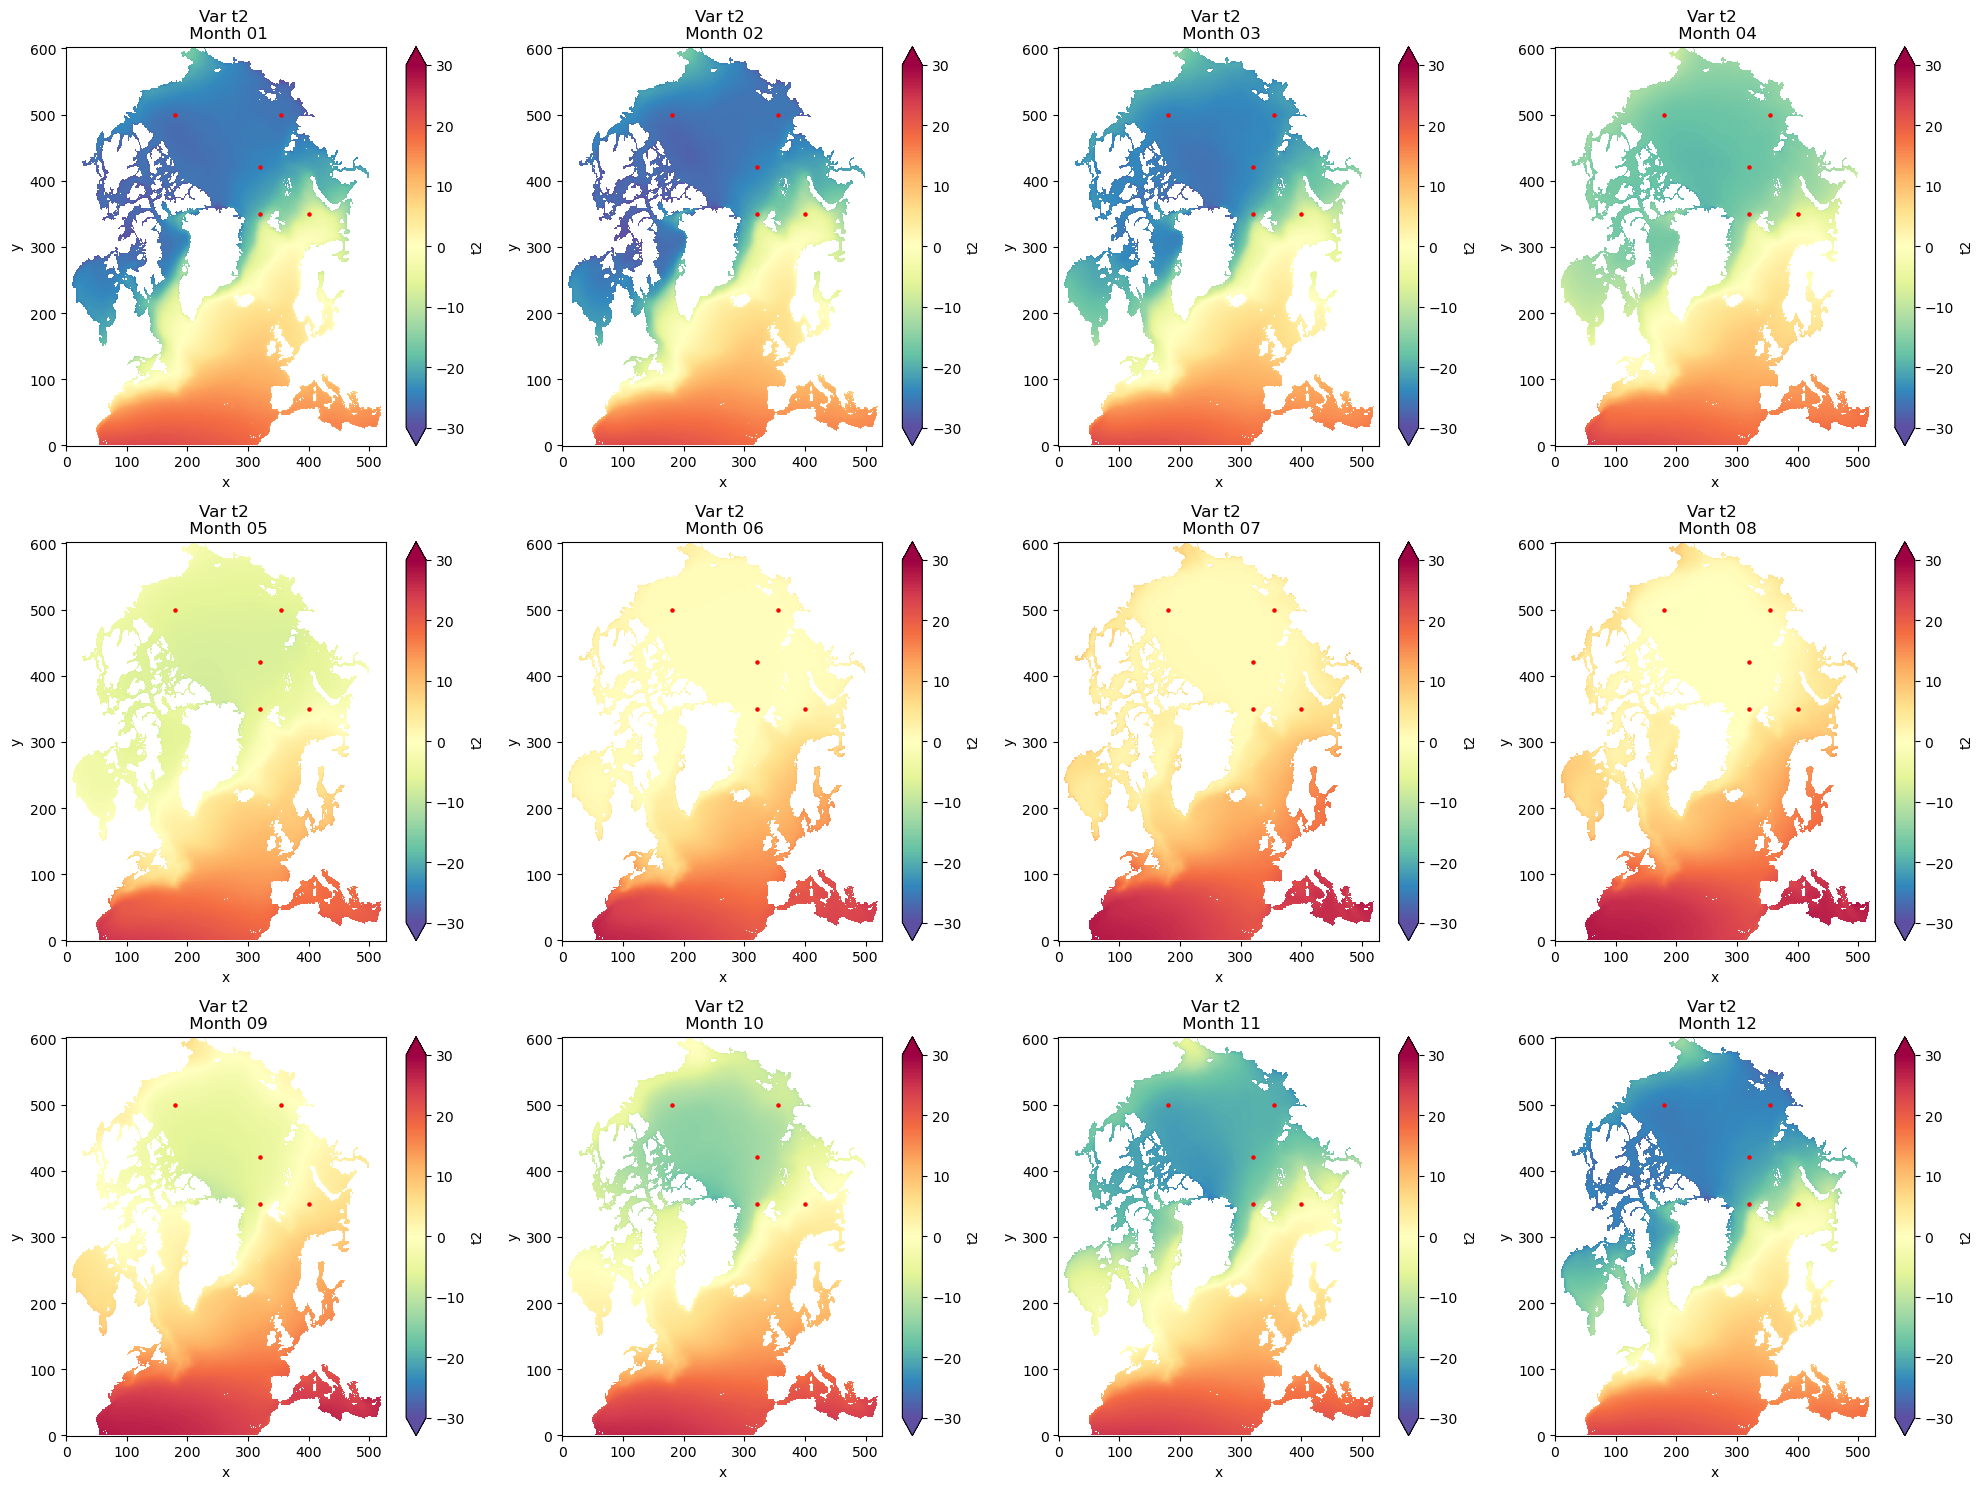

In [29]:
zvar='t2'
#zvar='t2sktdiff'

PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/'
if zvar == 't2sktdiff':
    ds_MonMean_Seas=xr.open_dataset(PATHIN+'t2skt/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')
else:
    ds_MonMean_Seas=xr.open_dataset(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')

zcmap='Spectral_r'
my_min=-30 ; my_max=30.    
if zvar == 't2' : 
    ds_MonMean_Seas[zvar]=xr.where(tmask2D == 0.,np.nan, ds_MonMean_Seas[zvar]-273.)


fig, axes = plt.subplots(3, 4, figsize=(20,15)) 

for i, ax in enumerate(axes.flat):
    i+=1 
    if i < 10: 
        mm='0'+str(i) 
    else : 
        mm=str(i)
    ds_MonMean_Seas[zvar].isel(month=i-1).plot(ax=ax,vmin=my_min,vmax=my_max,cmap=zcmap, extend='both')
    ax.set_title('Var '+zvar+' \n Month '+mm)
    ax.scatter(bx_LAPT['lon_min'],bx_LAPT['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_BGYR['lon_min'],bx_BGYR['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_SVAL['lon_min'],bx_SVAL['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_BARE['lon_min'],bx_BARE['lat_min'],5,marker='o', color='r')
    ax.scatter(bx_EURA['lon_min'],bx_EURA['lat_min'],5,marker='o', color='r')

plt.tight_layout()
if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_'+zvar+'_SeasMaps_y1981-2020.png',dpi=300)


# Time-series at specific mooring points of the seasonal cycle

In [8]:
PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/'
zvar='t2sktdiff'
ds_MonMean_Seas_skt=xr.open_dataset(PATHIN+'t2skt/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')
zvar='t2'
ds_MonMean_Seas_t2=xr.open_dataset(PATHIN+zvar+'/CREG025.L75_drowned_'+zvar+'_SeasCycle_ERA5_y1981-2020.nc')
ds_MonMean_Seas_t2['t2']=ds_MonMean_Seas_t2['t2']-273.

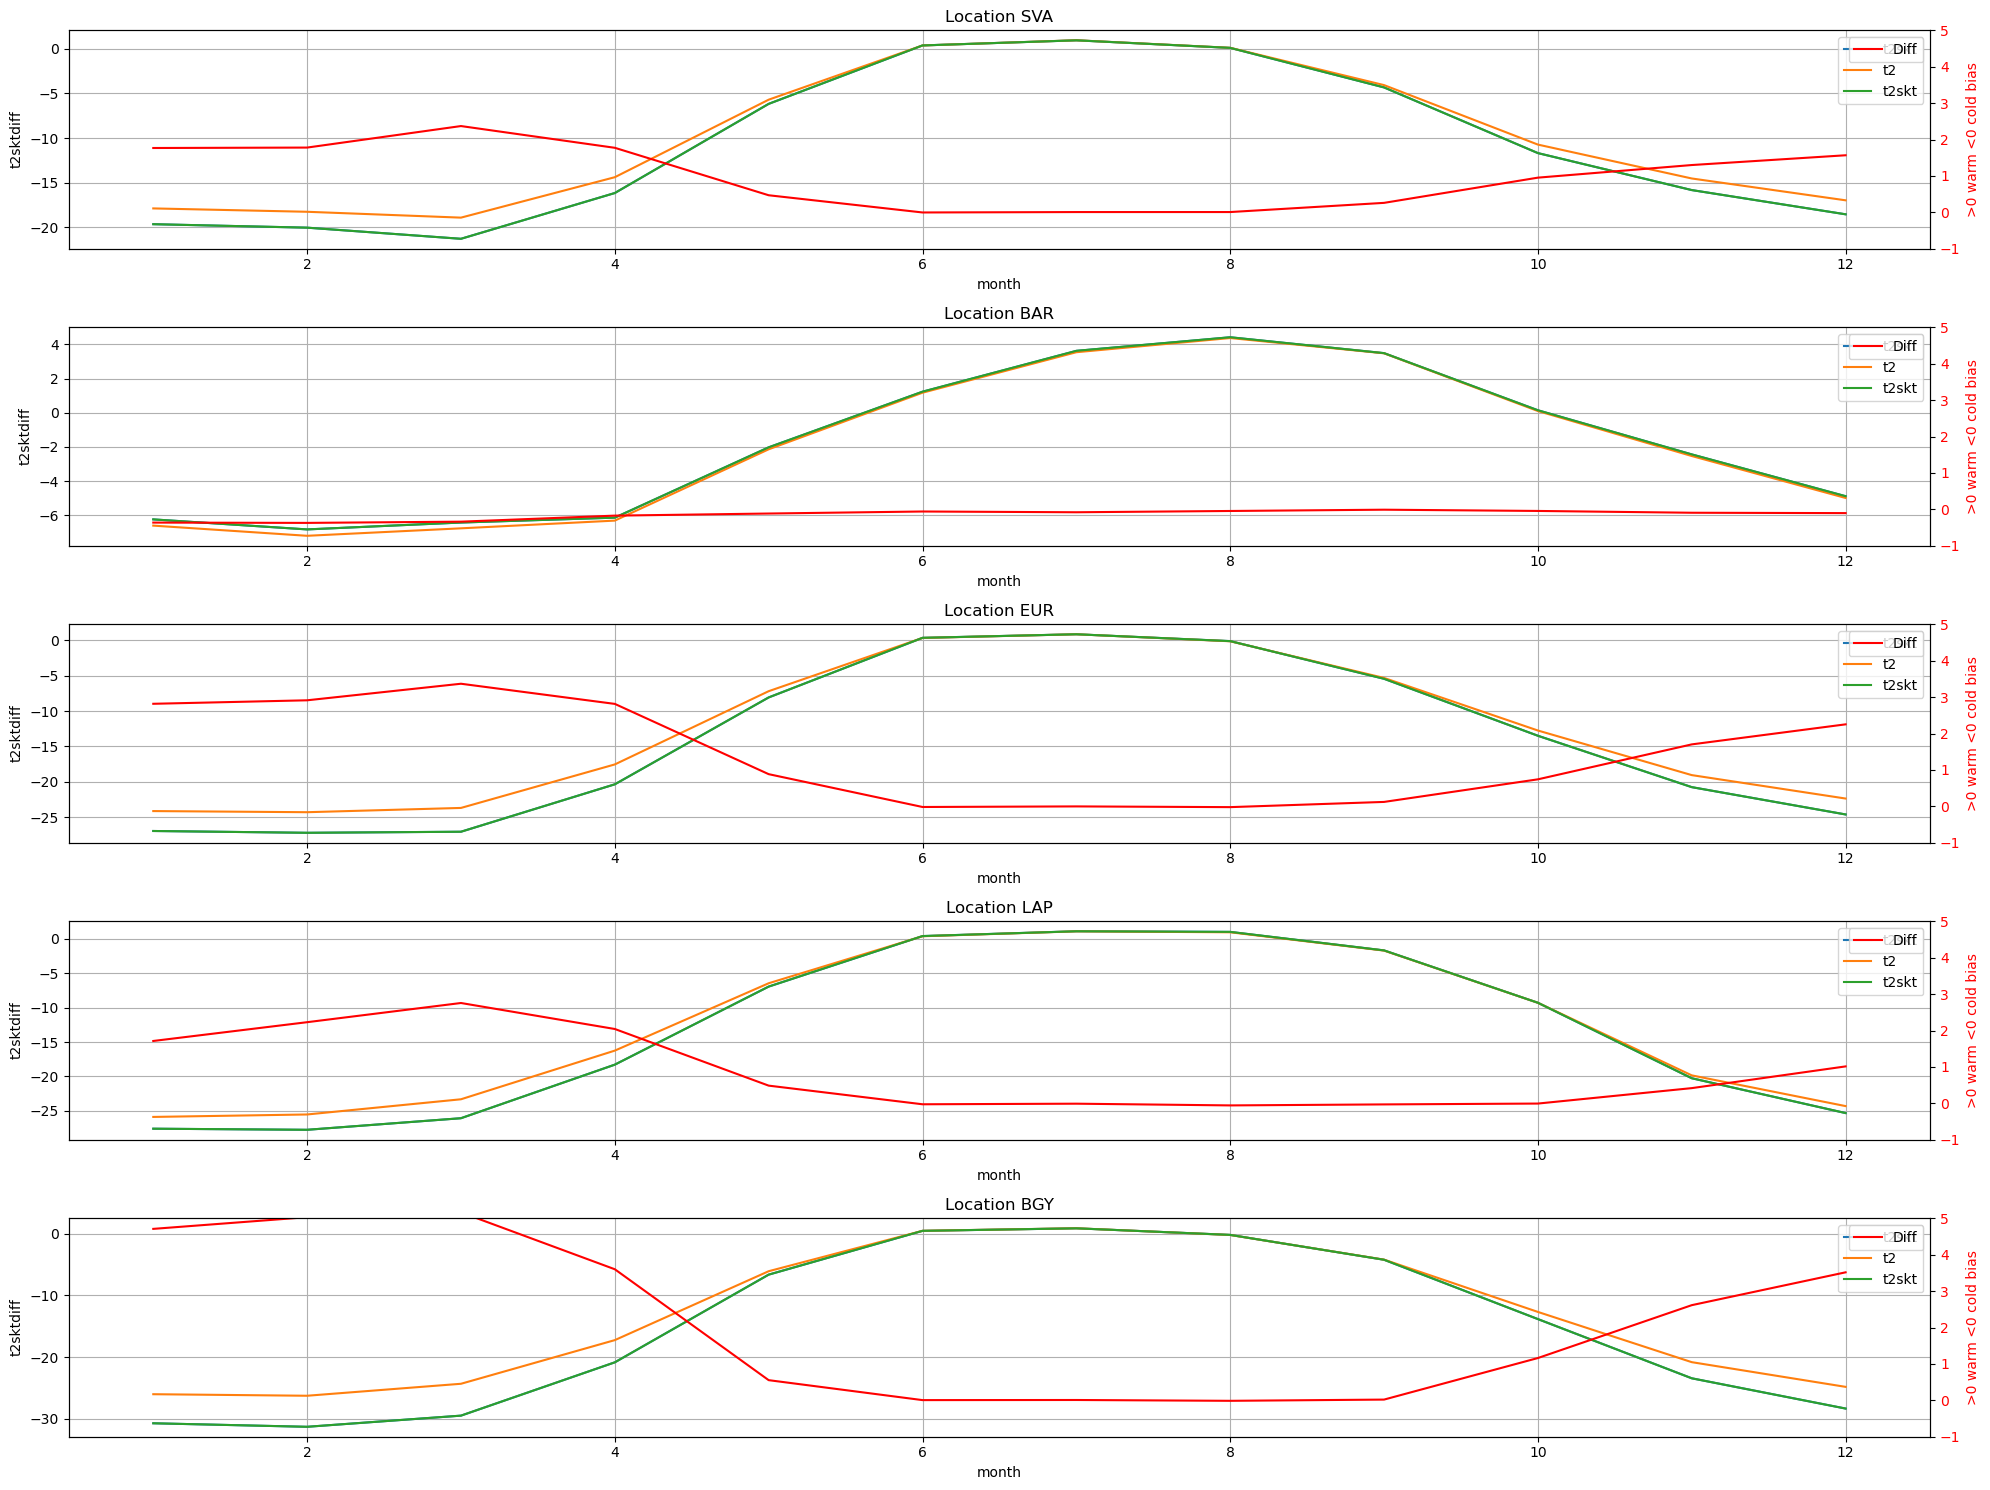

In [34]:
lst_boxes=[bx_SVAL,bx_BARE,bx_EURA,bx_LAPT,bx_BGYR]

fig, ax1 = plt.subplots(5,1,figsize=(20,15))

for i, axes in enumerate(ax1.flat):
    loc=lst_boxes[i]
    
    ds_MonMean_Seas_skt['t2sktdiff'].isel(x=loc['lon_min'],y=loc['lat_min']).plot(ax=axes,label='t2skt')
    ds_MonMean_Seas_t2['t2'].isel(x=loc['lon_min'],y=loc['lat_min']).plot(ax=axes,label='t2')
 
    if True:
        ax2=axes.twinx()
        ds_MonMean_Seas_skt['t2sktdiff'].isel(x=loc['lon_min'],y=loc['lat_min']).plot(ax=axes,label='t2skt')
        (ds_MonMean_Seas_t2['t2']-ds_MonMean_Seas_skt['t2sktdiff']).isel(x=loc['lon_min'],y=loc['lat_min'])\
        .plot(ax=ax2,label='Diff',color='r')
        ax2.tick_params(axis='y',labelcolor='r')
        ax2.legend()
        ax2.set_ylim([-1.,5.])
        ax2.set_ylabel('>0 warm <0 cold bias',color='r')

    axes.set_title('Location '+loc['name'])
    axes.legend()
    axes.grid(True)

    
fig.tight_layout()

if False: plt.savefig('./FIGURES/CREG025.L75-ERA5_t2sktdiff_SeasCyc_TiSe_y1981-2020.png',dpi=300)



# Plot the time-serie of mean temperature over the Arctic (>75°N) over the longest period

In [8]:
PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/'
skt_files = [f for f in fs.glob(PATHIN+'CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y*.nc')]
skt_files                           

['/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y1981.nc',
 '/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y1982.nc',
 '/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y1983.nc',
 '/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y1984.nc',
 '/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y1985.nc',
 '/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y1986.nc',
 '/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/CREG025.L75_drowned_t2sktdiff_MonMean_E

In [15]:
# Read the original t2 and corrected temperature fields 
PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2/'
ds_t2 = xr.concat([xr.open_dataset(f) for f in fs.glob(PATHIN+'CREG025.L75_drowned_t2_MonMean_ERA5_y*.nc')],dim='month')
ds_t2

PATHIN='/home/datawork-lops-drakkarcom/DATA-REFERENCE/ERA5-FORCING/SKIN-T/ERA5-CREG025.L75/t2skt/'
ds_t2skt = xr.concat([xr.open_dataset(f) for f in fs.glob(PATHIN+'CREG025.L75_drowned_t2sktdiff_MonMean_ERA5_y*.nc')],dim='month')


In [16]:
ds_t2
ds_t2=ds_t2.rename_dims({'month':'time_counter'})
ds_t2=ds_t2.drop_vars('month')

In [17]:
# Build a time axis starting from 197 up to 2020
new_time=pd.date_range(start='1979-01-01',end='2021-01-01',freq='MS',inclusive='left')+ pd.DateOffset(days=14)
new_time
ds_t2=ds_t2.assign_coords({'time_counter':new_time})
ds_t2

<xarray.Dataset>
Dimensions:       (time_counter: 504, y: 603, x: 528)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-01-15 ... 2020-12-15
Dimensions without coordinates: y, x
Data variables:
    t2            (time_counter, y, x) float32 292.2 292.3 292.4 ... 248.2 248.3

In [18]:
# Build a proper time axis
new_time=pd.date_range(start='1981-01-01',end='2021-01-01',freq='MS',inclusive='left')+ pd.DateOffset(days=14)
new_time

DatetimeIndex(['1981-01-15', '1981-02-15', '1981-03-15', '1981-04-15',
               '1981-05-15', '1981-06-15', '1981-07-15', '1981-08-15',
               '1981-09-15', '1981-10-15',
               ...
               '2020-03-15', '2020-04-15', '2020-05-15', '2020-06-15',
               '2020-07-15', '2020-08-15', '2020-09-15', '2020-10-15',
               '2020-11-15', '2020-12-15'],
              dtype='datetime64[ns]', length=480, freq=None)

In [19]:
# Now a new Dataset with this time axis
ds_MonMean=xr.Dataset()

ds_MonMean['t2skt']=(('time','y','x'),ds_t2skt['t2sktdiff'].data)
ds_MonMean['t2']=(('time','y','x'),ds_t2['t2'].sel(time_counter=slice('1981','2020')).data)

ds_MonMean=ds_MonMean.assign_coords({'time':new_time})
ds_MonMean

<xarray.Dataset>
Dimensions:  (time: 480, y: 603, x: 528)
Coordinates:
  * time     (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2020-12-15
Dimensions without coordinates: y, x
Data variables:
    t2skt    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    t2       (time, y, x) float32 292.0 291.9 291.9 291.9 ... 248.0 248.2 248.3

In [21]:

aKelvin=-273.15

ds_MonMean['t2_deg']=ds_MonMean.t2+aKelvin

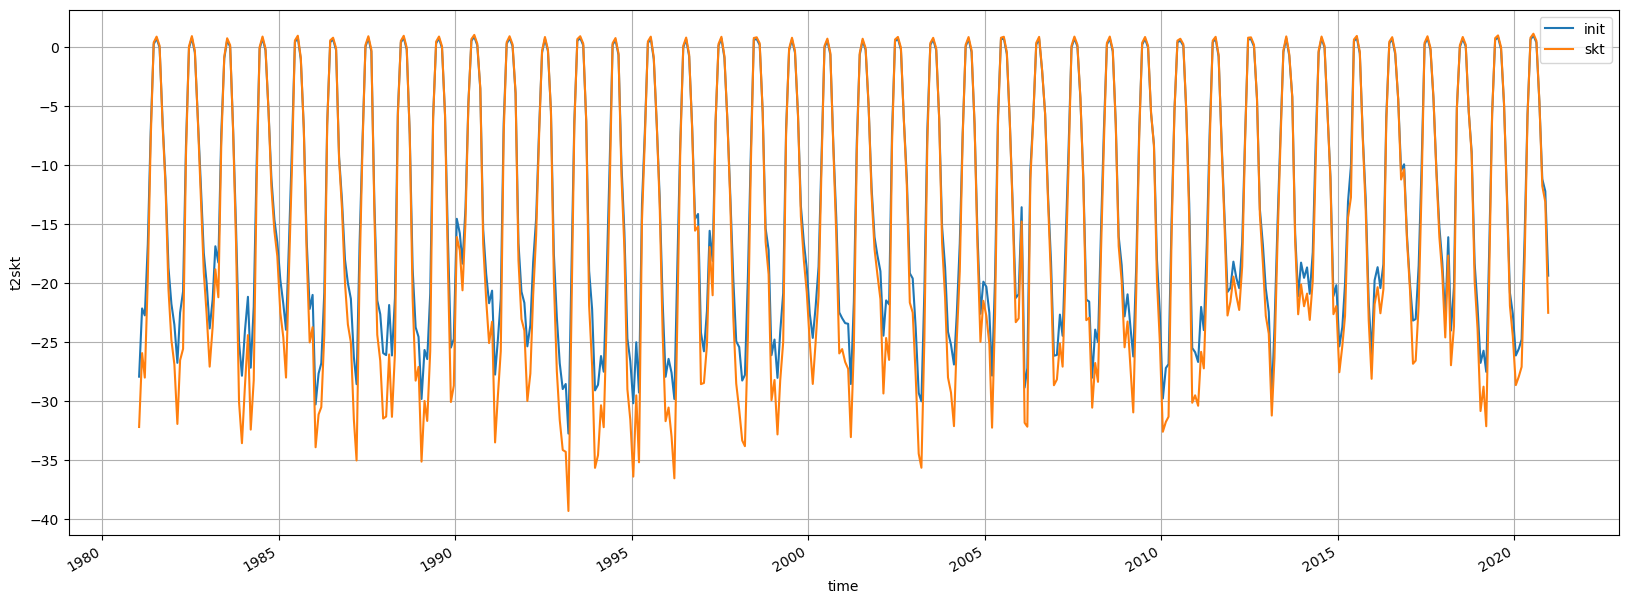

In [22]:
plt.figure(figsize=(20,15)) 
plt.subplot(211)
ds_MonMean.t2_deg.isel(x=300,y=400).plot(label='init')
ds_MonMean.t2skt.isel(x=300,y=400).plot(label='skt')
#plt.xlim(['2000','2001'])
plt.legend()
plt.grid(True)

# Define a mask over the Artic area only 

In [23]:

# Read de Domain config file
INDIR='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG025.L75/GRID/'
ds_cfg=xr.open_dataset(INDIR+'CREG025.L75_domain_cfg.nc')
ds_cfg

# Define a land-sea mask in an other way
lsm=xr.where(ds_cfg['bottom_level']>0,1.,0.)

In [24]:
cd_cfg=ds_cfg.set_coords(['nav_lat','nav_lon'])

In [25]:
cd_cfg['tmask']=(('y','x'),lsm[0,:,:].data)

In [26]:
cd_cfg

<xarray.Dataset>
Dimensions:       (y: 603, x: 528, z: 75, t: 1)
Coordinates:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
Dimensions without coordinates: y, x, z, t
Data variables: (12/41)
    nav_lev       (z) float32 ...
    time_counter  (t) float64 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    jperio        int32 ...
    ...            ...
    e3uw_0        (t, z, y, x) float64 ...
    e3vw_0        (t, z, y, x) float64 ...
    bottom_level  (t, y, x) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    top_level     (t, y, x) int32 ...
    bathy_meter   (t, y, x) float32 ...
    tmask         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    file_name:  domain_cfg.nc
    TimeStamp:  08/07/2019 18:14:20 +0200

In [27]:
cd_cfg['tmask']=xr.where(cd_cfg['nav_lat'] < 70.,0.,lsm[0,:,:].data )

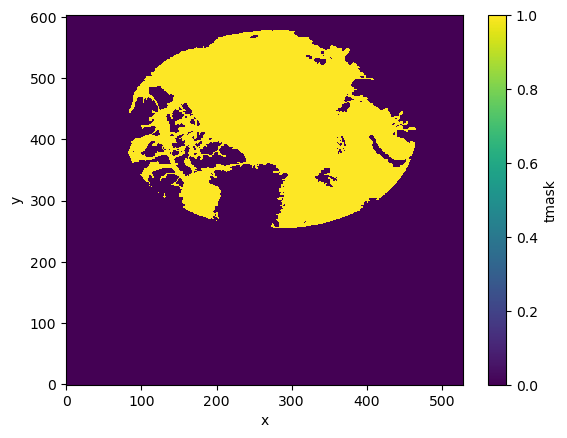

In [28]:
cd_cfg['tmask'].plot()

# Now compute the mean temperature over this area

In [29]:
ds_MonMean['e1te2t_msk']=cd_cfg.tmask*cd_cfg.e1t[0,:,:]*cd_cfg.e2t[0,:,:]
ds_MonMean['e1te2t_mskSum']=np.sum(ds_MonMean['e1te2t_msk'].data)

In [30]:
ds_MonMean

<xarray.Dataset>
Dimensions:        (time: 480, y: 603, x: 528)
Coordinates:
  * time           (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2020-12-15
    nav_lon        (y, x) float32 -93.75 -93.5 -93.25 ... 102.4 102.2 102.0
    nav_lat        (y, x) float32 25.36 25.36 25.36 25.36 ... 55.09 55.02 54.95
Dimensions without coordinates: y, x
Data variables:
    t2skt          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    t2             (time, y, x) float32 292.0 291.9 291.9 ... 248.0 248.2 248.3
    t2_deg         (time, y, x) float32 18.81 18.77 18.75 ... -25.0 -24.82
    e1te2t_msk     (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    e1te2t_mskSum  float64 1.14e+13

In [31]:
ds_MonMean['Arctic_meant2']=np.sum(ds_MonMean.t2_deg*ds_MonMean.e1te2t_msk,axis=(1,2))/ds_MonMean.e1te2t_mskSum
ds_MonMean['Arctic_meant2skt']=np.sum(ds_MonMean.t2skt*ds_MonMean.e1te2t_msk,axis=(1,2))/ds_MonMean.e1te2t_mskSum

In [32]:
ds_MonMean

<xarray.Dataset>
Dimensions:           (time: 480, y: 603, x: 528)
Coordinates:
  * time              (time) datetime64[ns] 1981-01-15 1981-02-15 ... 2020-12-15
    nav_lon           (y, x) float32 -93.75 -93.5 -93.25 ... 102.4 102.2 102.0
    nav_lat           (y, x) float32 25.36 25.36 25.36 ... 55.09 55.02 54.95
Dimensions without coordinates: y, x
Data variables:
    t2skt             (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    t2                (time, y, x) float32 292.0 291.9 291.9 ... 248.2 248.3
    t2_deg            (time, y, x) float32 18.81 18.77 18.75 ... -25.0 -24.82
    e1te2t_msk        (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    e1te2t_mskSum     float64 1.14e+13
    Arctic_meant2     (time) float64 -21.08 -20.38 -20.73 ... -10.14 -17.37
    Arctic_meant2skt  (time) float64 -23.39 -22.95 -23.88 ... -10.43 -18.05

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


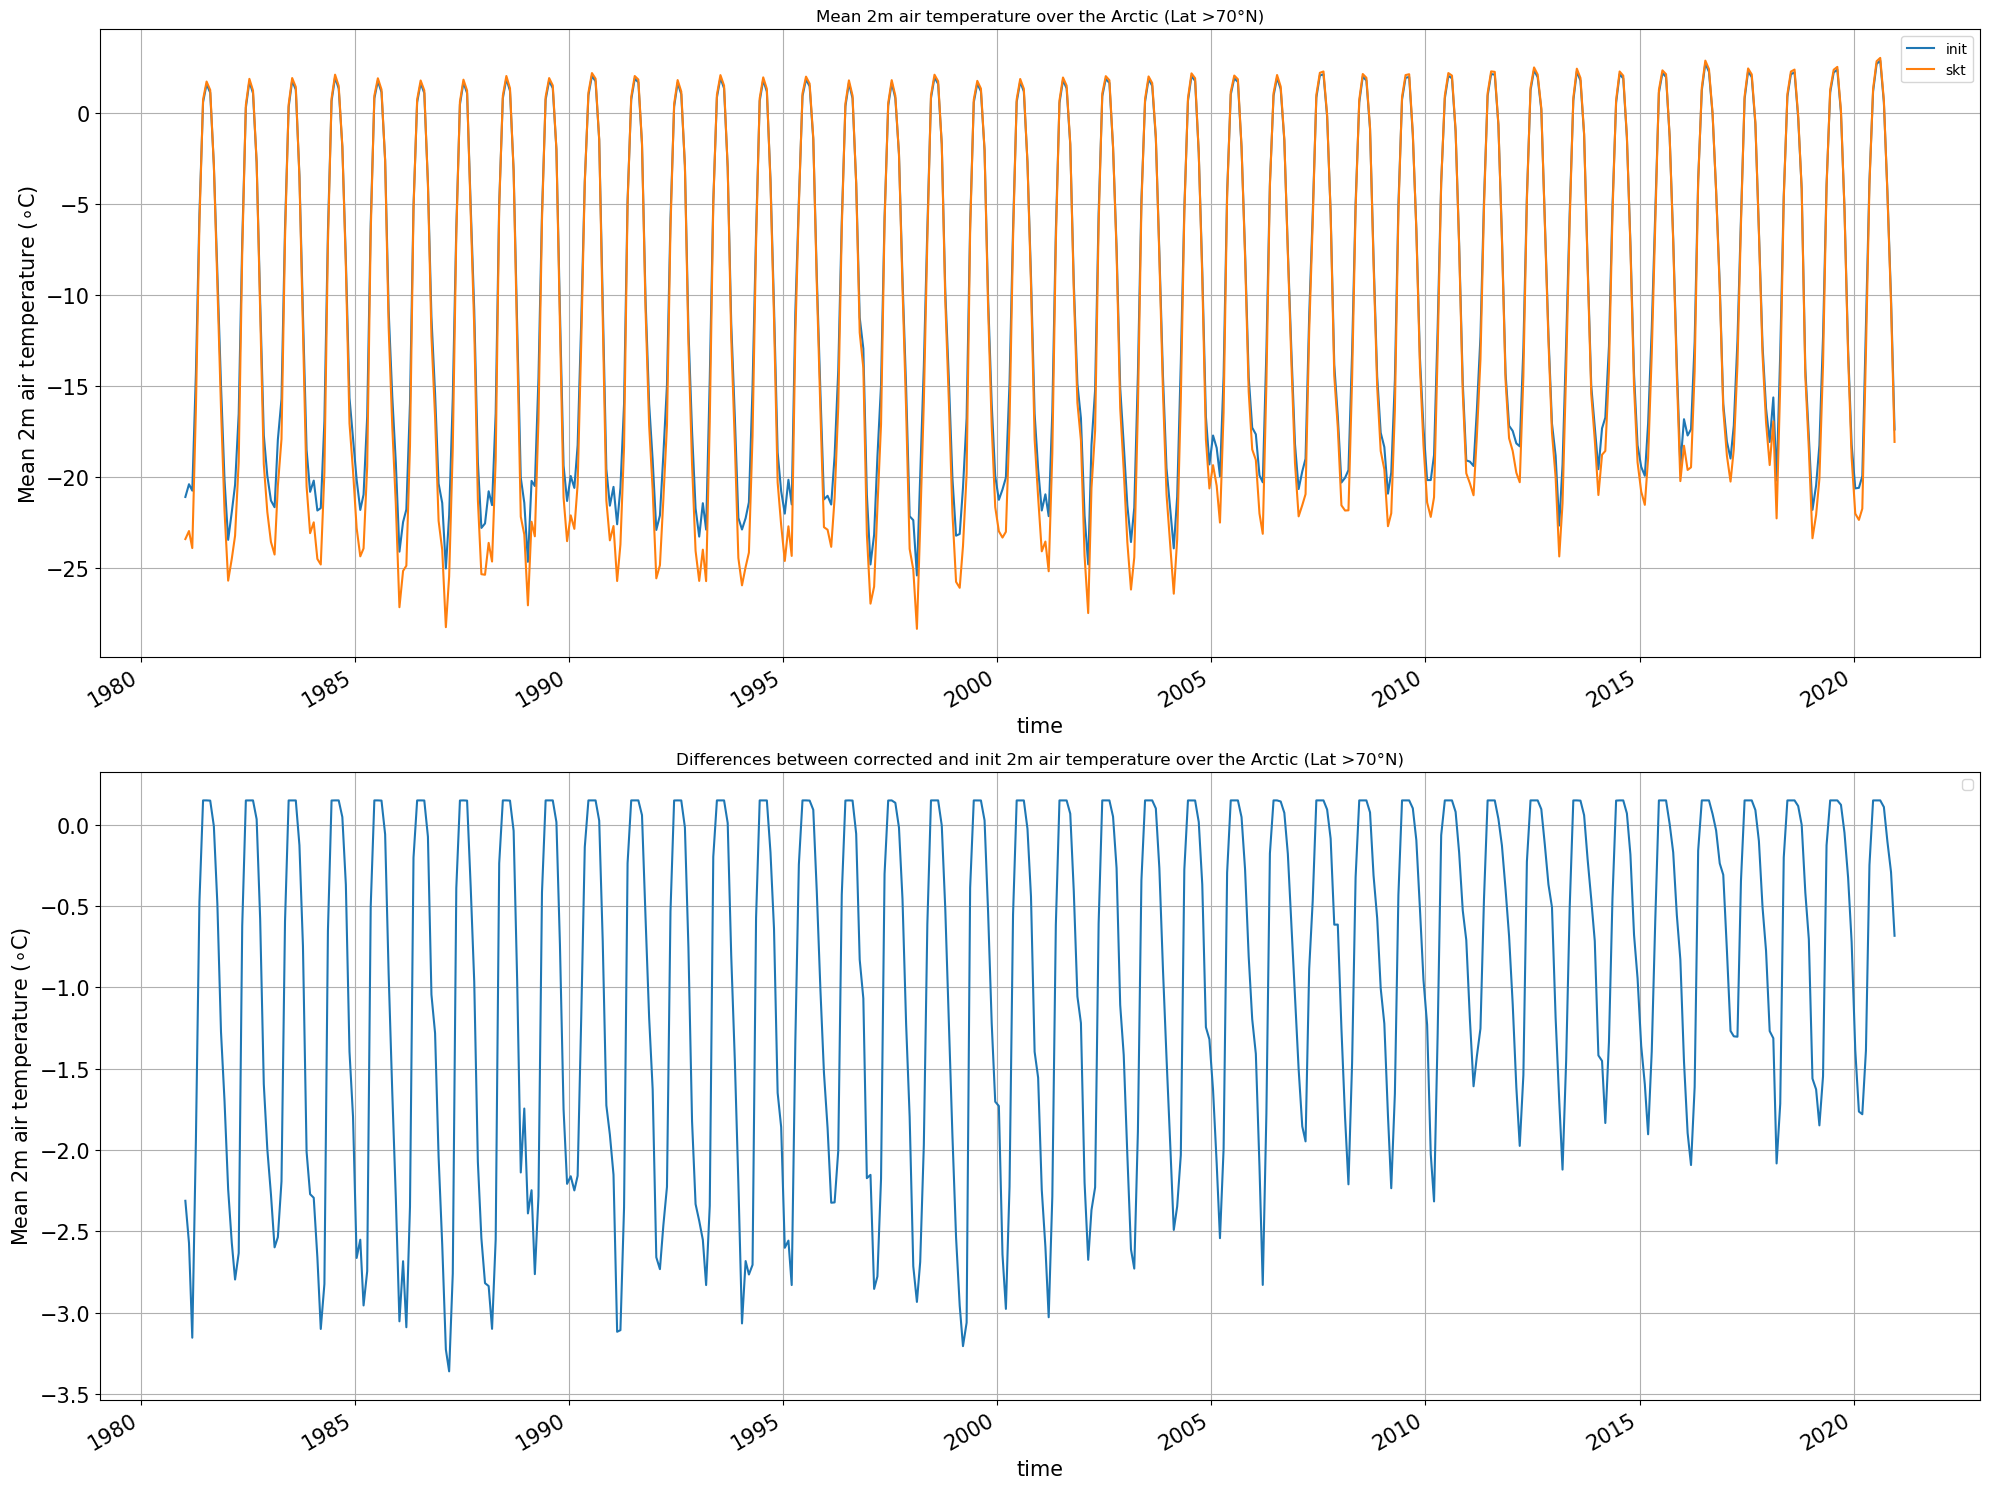

In [33]:
aKelvin=-273.15
plt.figure(figsize=(20,15)) 
plt.subplot(211)
ds_MonMean.Arctic_meant2.plot(label='init')
ds_MonMean.Arctic_meant2skt.plot(label='skt')
plt.title('Mean 2m air temperature over the Arctic (Lat >70°N)')
plt.xlabel('time',fontsize=15)
plt.ylabel('Mean 2m air temperature ($\circ$C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.grid(True)

plt.subplot(212)
(ds_MonMean.Arctic_meant2skt-ds_MonMean.Arctic_meant2).plot()
plt.title('Differences between corrected and init 2m air temperature over the Arctic (Lat >70°N)')
plt.xlabel('time',fontsize=15)
plt.ylabel('Mean 2m air temperature ($\circ$C)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('./FIGURES/ERA5_Arctic_Mean_2mTemp_y1981-2020.png',dpi=300)